# Battle of the Neighborhoods: Makati and Mandaluyong City

## Importing libraries

In [19]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas import DataFrame

import json # library to handle JSON files

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium # map rendering library

#!pip install beautifulsoup4
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


# 1) Barangays of Makati City

## Web scraping to retrieve barangay names

In [24]:
#Scraping the HTML
URL = 'https://en.wikipedia.org/wiki/Makati#Barangays'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find('table', class_='sortable')

barangay = []


for row in table.find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        barangay.append(cells[0].text.rstrip('\n'))


        
data = {'Barangay': barangay,}
#Creating the Data frame
makati = pd.DataFrame(data, columns=['Barangay'])
makati.head()


,Barangay
0,Bangkal
1,Bel-Air
2,Carmona
3,Cembo
4,Comembo


## Using geocoder to find the latitude and longitude of each barangay

In [8]:
def get_latlng(barangay):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Makati, Philippines'.format(barangay))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [13]:
coords = [ get_latlng(barangay) for barangay in makati['Barangay'].tolist() ]
coords

[[14.543590000000052, 121.01315000000011],
 [14.561450000000036, 121.02362000000005],
 [14.576220000000035, 121.0172500000001],
 [14.565350000000024, 121.05088],
 [14.548410000000047, 121.06393000000003],
 [14.539850000000058, 121.02822000000003],
 [14.555150000000026, 121.06254000000001],
 [14.545980000000043, 121.03687000000002],
 [14.561030000000073, 121.04664000000002],
 [14.565850000000069, 121.04166000000009],
 [14.575920000000053, 121.01331000000005],
 [14.568340000000035, 121.00936000000002],
 [14.535340000000076, 121.0179700000001],
 [14.569330000000036, 121.01916000000006],
 [14.559960000000046, 121.0027500000001],
 [14.545190000000048, 121.05978000000005],
 [14.557650000000024, 121.04030000000012],
 [14.553790000000049, 121.01069000000007],
 [14.556900000000041, 121.04513000000009],
 [14.566340000000025, 121.03168000000005],
 [14.553210000000036, 121.05154000000005],
 [14.545010000000048, 121.04784000000006],
 [14.537300000000073, 121.06097000000011],
 [14.563500000000033, 1

In [26]:
df_coords = DataFrame(coords,columns=['Latitude','Longitude'])
df_coords.head()

,Latitude,Longitude
0,14.54359,121.01315
1,14.56145,121.02362
2,14.57622,121.01725
3,14.56535,121.05088
4,14.54841,121.06393


## Combining the barangay names and the latitude and longitude values into one dataframe

In [311]:
makati_coordinates = pd.concat([makati, df], axis=1)
makati_coordinates.head()

,Barangay,Latitude,Longitude
0,Bangkal,14.54359,121.01315
1,Bel-Air,14.56145,121.02362
2,Carmona,14.57622,121.01725
3,Cembo,14.56535,121.05088
4,Comembo,14.54841,121.06393


## Using geopy library to get the latitude and longitude values of Makati City


In [10]:
address = 'Makati City, Philippines'
geolocator = Nominatim(user_agent="makati_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Makati City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Makati City are 14.5568853, 121.023532.


## Creating a map using Folium

In [30]:
map_makati = folium.Map(location=[latitude, longitude], zoom_start=11)

for brgy, lat, long in zip(makati_coordinates['Barangay'], makati_coordinates['Latitude'], makati_coordinates['Longitude']):
    label = "{} ({}): {}".format(barangay, latitude, longitude)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_makati)
    
map_makati

## Defining Foursquare credentials

In [31]:
CLIENT_ID = '5UOY4YCHDHYPV35DCH3GUZLX0LU4GITNBXD0B2YI1TH33GZ5' # your Foursquare ID
CLIENT_SECRET = '1B0XGEFV3DDA3HNTFUR33V20TC1L1QSPORAOI1CIKKW2UEKC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5UOY4YCHDHYPV35DCH3GUZLX0LU4GITNBXD0B2YI1TH33GZ5
CLIENT_SECRET:1B0XGEFV3DDA3HNTFUR33V20TC1L1QSPORAOI1CIKKW2UEKC


## Getting nearby venues

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name,
                             lat,
                             lng,
                             v['venue']['name'],
                             v['venue']['location']['lat'],
                             v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Barangay', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
LIMIT=100
makati_venues = getNearbyVenues(names=makati_coordinates['Barangay'],
                                   latitudes=makati_coordinates['Latitude'],
                                   longitudes=makati_coordinates['Longitude']
                                  )

In [40]:
makati_venues.head()

,Barangay,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bangkal,14.54359,121.01315,100g Burger's,14.545715,121.013222,Burger Joint
1,Bangkal,14.54359,121.01315,Kaito Japanese Carinderia,14.543683,121.012782,Japanese Restaurant
2,Bangkal,14.54359,121.01315,FitFast Wellness and Fitness Center,14.547046,121.014352,Gym
3,Bangkal,14.54359,121.01315,Spare Strike,14.540995,121.011987,Tapas Restaurant
4,Bangkal,14.54359,121.01315,Nova Gallery,14.544795,121.016941,Art Gallery


## Determining the number of venues for each barangay

In [41]:
makati_venues.groupby('Barangay').size()

Barangay
Bangkal                                       33
Bel-Air                                       86
Carmona                                       34
Cembo                                          4
Comembo                                       14
Dasmariñas                                     4
East Rembo                                     4
Forbes Park                                   25
Guadalupe Nuevo                               20
Guadalupe Viejo                               21
Kasilawan                                     14
La Paz                                        31
Magallanes                                    23
Olympia                                       27
Palanan                                       24
Pembo                                          5
Pinagkaisahan                                  6
Pio del Pilar                                 67
Pitogo                                        65
Poblacion                                     57
Post Proper

In [42]:
print('There are {} uniques categories.'.format(len(makati_venues['Venue Category'].unique())))

There are 183 uniques categories.


## Analyzing each neighborhood using one-hot encoding

In [62]:
# one hot encoding
makati_onehot = pd.get_dummies(makati_venues[['Venue Category']], prefix="", prefix_sep="")

# add barangay column back to dataframe
makati_onehot['Barangay'] = makati_venues['Barangay']

# move neighborhood column to the first column
fixed_columns = [makati_onehot.columns[-1]] + list(makati_onehot.columns[:-1])
makati_onehot = makati_onehot[fixed_columns]

makati_onehot.head()

,Barangay,American Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Cafeteria,Café,Cantonese Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Drugstore,Dumpling Restaurant,Empanada Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Hobby Shop,Hospital,Hostel,Hotel,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Motel,Movie Theater,Multiplex,Music Venue,New American Restaurant,Nightclub,Nursery School,Okonomiyaki Restaurant,Outdoor Event Space,Paella Restaurant,Park,Pastry Shop,Pawn Shop,Performing Arts Venue,Perfume Shop,Pet Service,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Repair,Shop & Service,Shopping Mall,Shopping Plaza,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio
0,Bangkal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bangkal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bangkal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bangkal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Grouping by barangay and finding the mean of the frequency of occurrence 

In [63]:
makati_grouped = makati_onehot.groupby('Barangay').mean().reset_index()
makati_grouped.head()

,Barangay,American Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Cafeteria,Café,Cantonese Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Drugstore,Dumpling Restaurant,Empanada Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Hobby Shop,Hospital,Hostel,Hotel,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Motel,Movie Theater,Multiplex,Music Venue,New American Restaurant,Nightclub,Nursery School,Okonomiyaki Restaurant,Outdoor Event Space,Paella Restaurant,Park,Pastry Shop,Pawn Shop,Performing Arts Venue,Perfume Shop,Pet Service,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Repair,Shop & Service,Shopping Mall,Shopping Plaza,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio
0,Bangkal,0.0,0.090909,0.000000,0.030303,0.000000,0.000000,0.0,0.030303,0.000000,0.060606,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.030303,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.030303,0.0,0.000000,0.060606,0.000000,0.0,0.0,0.121212,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.030303,0.030303,0.0,0.0,0.0,0.0,0.000000,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.060606,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.030303,0.000000,0.030303,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.030303,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.060606,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.030303,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.030303,0.030303,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.030303,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.030303,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.030303,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,Bel-Air,0.0,0.000000,0.011628,0.000000,0.000000,0.011628,0.0,0.000000,0.011628,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.011628,0.0,0.0,0.0,0.000000,0.0,0.0,0.011628,0.0,0.011628,0.000000,0.0,0.0,0.0,0.034884,0.0,0.0,0.011628,0.0,0.0

## Determining the most common venues

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Barangay']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) # 1st, 2nd, 3rd
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
makati_venues_sorted = pd.DataFrame(columns=columns)
makati_venues_sorted['Barangay'] = makati_grouped['Barangay']

# Each row of the new dataframe is filled with the sorted categories of each row of makati_goruped dataframe
for ind in np.arange(makati_grouped.shape[0]):
    makati_venues_sorted.iloc[ind, 1:] = return_most_common_venues(makati_grouped.iloc[ind, :], num_top_venues)

makati_venues_sorted.head()

,Barangay,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bangkal,Convenience Store,Art Gallery,Fast Food Restaurant,Furniture / Home Store,Nightclub,Cocktail Bar,Bar,Hardware Store,Burger Joint,Sporting Goods Shop
1,Bel-Air,Coffee Shop,Pizza Place,Steakhouse,Spa,Japanese Restaurant,Restaurant,Café,Filipino Restaurant,Creperie,Donut Shop
2,Carmona,Convenience Store,Coffee Shop,Fast Food Restaurant,BBQ Joint,Burrito Place,Shopping Plaza,Burger Joint,Dim Sum Restaurant,Café,Outdoor Event Space
3,Cembo,Basketball Court,Convenience Store,Pharmacy,Park,Diner,Donut Shop,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
4,Comembo,Fast Food Restaurant,Convenience Store,Diner,Chinese Restaurant,Asian Restaurant,Breakfast Spot,Fish Market,Gym / Fitness Center,Frozen Yogurt Shop,Fried Chicken Joint


## Clustering using K-Means

In [100]:
kclusters = 3

makati_grouped_clustering = makati_grouped.drop('Barangay', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(makati_grouped_clustering)

kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 2, 1, 0, 1, 1])

In [101]:
#create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
makati_merged = makati_coordinates.copy()

# add clustering labels
makati_merged["Cluster Labels"] = kmeans.labels_
makati_merged.rename(columns={"Barangay": "Barangay"}, inplace=True)

makati_merged = makati_merged.join(makati_venues_sorted.set_index("Barangay"), on="Barangay")

makati_merged.head()

,Barangay,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bangkal,14.54359,121.01315,0,Convenience Store,Art Gallery,Fast Food Restaurant,Furniture / Home Store,Nightclub,Cocktail Bar,Bar,Hardware Store,Burger Joint,Sporting Goods Shop
1,Bel-Air,14.56145,121.02362,0,Coffee Shop,Pizza Place,Steakhouse,Spa,Japanese Restaurant,Restaurant,Café,Filipino Restaurant,Creperie,Donut Shop
2,Carmona,14.57622,121.01725,0,Convenience Store,Coffee Shop,Fast Food Restaurant,BBQ Joint,Burrito Place,Shopping Plaza,Burger Joint,Dim Sum Restaurant,Café,Outdoor Event Space
3,Cembo,14.56535,121.05088,0,Basketball Court,Convenience Store,Pharmacy,Park,Diner,Donut Shop,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
4,Comembo,14.54841,121.06393,1,Fast Food Restaurant,Convenience Store,Diner,Chinese Restaurant,Asian Restaurant,Breakfast Spot,Fish Market,Gym / Fitness Center,Frozen Yogurt Shop,Fried Chicken Joint


## Visualizing the clusters using a map

In [102]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, brgy, cluster in zip(makati_merged['Latitude'], makati_merged['Longitude'],
                                makati_merged['Barangay'], makati_merged['Cluster Labels']):
    label = folium.Popup('{} - Cluster {}'.format(brgy, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining the clusters

In [103]:
makati_merged.groupby('Cluster Labels').count()

,Barangay,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,
0,26,26,26,26,26,26,26,26,26,26,26,26,26
1,6,6,6,6,6,6,6,6,6,6,6,6,6
2,1,1,1,1,1,1,1,1,1,1,1,1,1


### Cluster 0

In [112]:
makati_merged.loc[makati_merged['Cluster Labels'] == 0]

,Barangay,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bangkal,14.54359,121.01315,0,Convenience Store,Art Gallery,Fast Food Restaurant,Furniture / Home Store,Nightclub,Cocktail Bar,Bar,Hardware Store,Burger Joint,Sporting Goods Shop
1,Bel-Air,14.56145,121.02362,0,Coffee Shop,Pizza Place,Steakhouse,Spa,Japanese Restaurant,Restaurant,Café,Filipino Restaurant,Creperie,Donut Shop
2,Carmona,14.57622,121.01725,0,Convenience Store,Coffee Shop,Fast Food Restaurant,BBQ Joint,Burrito Place,Shopping Plaza,Burger Joint,Dim Sum Restaurant,Café,Outdoor Event Space
3,Cembo,14.56535,121.05088,0,Basketball Court,Convenience Store,Pharmacy,Park,Diner,Donut Shop,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
7,Forbes Park,14.54598,121.03687,0,Japanese Restaurant,Italian Restaurant,Lounge,Deli / Bodega,Coffee Shop,Café,Bookstore,Indian Restaurant,Grocery Store,Golf Course
10,Kasilawan,14.57592,121.01331,0,Convenience Store,Juice Bar,Bakery,Supermarket,Fried Chicken Joint,Cafeteria,Fast Food Restaurant,Shop & Service,Sports Club,BBQ Joint
11,La Paz,14.56834,121.00936,0,Filipino Restaurant,Hotel,Bar,Pharmacy,Restaurant,Gas Station,Coffee Shop,Burger Joint,Donut Shop,Bubble Tea Shop
12,Magallanes,14.53534,121.01797,0,Diner,Coffee Shop,Pizza Place,Mattress Store,Sports Bar,Café,Steakhouse,Food & Drink Shop,Music Venue,Tapas Restaurant
13,Olympia,14.56933,121.01916,0,Convenience Store,Filipino Restaurant,Donut Shop,Fast Food Restaurant,Dim Sum Restaurant,Spa,Café,Pastry Shop,Multiplex,Shopping Mall
14,Palanan,14.55996,121.00275,0,Pizza Place,Coffee Shop,Pharmacy,Fast Food Restaurant,Filipino Restaurant,Bakery,Garden,Bookstore,Cupcake Shop,Shopping Mall


### Cluster 1

In [113]:
makati_merged.loc[makati_merged['Cluster Labels'] == 1]

,Barangay,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Comembo,14.54841,121.06393,1,Fast Food Restaurant,Convenience Store,Diner,Chinese Restaurant,Asian Restaurant,Breakfast Spot,Fish Market,Gym / Fitness Center,Frozen Yogurt Shop,Fried Chicken Joint
6,East Rembo,14.55515,121.06254,1,Fast Food Restaurant,Basketball Court,Breakfast Spot,Filipino Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
8,Guadalupe Nuevo,14.56103,121.04664,1,Convenience Store,Fast Food Restaurant,Basketball Court,Bus Line,Pet Store,Pawn Shop,Breakfast Spot,Bakery,Farmers Market,Motel
9,Guadalupe Viejo,14.56585,121.04166,1,Fast Food Restaurant,Convenience Store,Restaurant,Café,Bakery,Deli / Bodega,Pawn Shop,Italian Restaurant,Market,Boutique
15,Pembo,14.54519,121.05978,1,Convenience Store,Soba Restaurant,Pizza Place,Fast Food Restaurant,Falafel Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Fish Market
32,West Rembo,14.56162,121.05954,1,Fast Food Restaurant,Convenience Store,Asian Restaurant,Breakfast Spot,Sandwich Place,Soccer Stadium,Gastropub,Pool,Coffee Shop,Tapas Restaurant


### Cluster 2

In [114]:
makati_merged.loc[makati_merged['Cluster Labels'] == 2]

,Barangay,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Dasmariñas,14.53985,121.02822,2,Soccer Field,Café,Gym,Baseball Field,Yoga Studio,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


# 2) Barangays of Mandaluyong City

## Web scraping to retrieve barangay names

In [126]:
#Scraping the HTML
URL2 = 'https://en.wikipedia.org/wiki/Mandaluyong#Barangays'
page2 = requests.get(URL2)

soup2 = BeautifulSoup(page2.content, 'html.parser')
table2 = soup2.find('table', class_='sortable')

barangay2 = []


for row in table2.find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        barangay2.append(cells[1].text.rstrip('\n'))


        
data2 = {'Barangay': barangay2}
#Creating the Data frame
mandaluyong = pd.DataFrame(data2, columns=['Barangay'])
mandaluyong.head()


,Barangay
0,Addition Hills
1,Bagong Silang
2,Barangka Drive
3,Barangka Ibaba
4,Barangka Ilaya


## Using geocoder to find the latitude and longitude of each barangay

In [145]:
def get_latlng2(barangay):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Mandaluyong, Philippines'.format(barangay))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [146]:
coords2 = [ get_latlng2(barangay) for barangay in mandaluyong['Barangay'].tolist() ]
coords2

[[14.586600000000033, 121.03829000000007],
 [14.591820000000041, 121.03091000000006],
 [14.57271000000003, 121.03796000000011],
 [14.57018000000005, 121.03926000000001],
 [14.571830000000034, 121.04789000000005],
 [14.571320000000071, 121.0426500000001],
 [14.57403000000005, 121.05357000000004],
 [14.590070000000026, 121.02691000000004],
 [14.592960000000062, 121.02866000000006],
 [14.588610000000074, 121.02960000000007],
 [14.588840000000062, 121.03417000000002],
 [14.590870000000052, 121.02784000000008],
 [14.57901000000004, 121.05033000000003],
 [14.570570000000032, 121.03214000000003],
 [14.583300000000065, 121.02200000000005],
 [14.575020000000052, 121.04432000000008],
 [14.582810000000052, 121.04524000000004],
 [14.580370000000073, 121.02104000000008],
 [14.581000000000074, 121.02580000000012],
 [14.57970000000006, 121.02550000000008],
 [14.590240000000051, 121.02451000000008],
 [14.576230000000066, 121.03383000000008],
 [14.588450000000023, 121.04007000000001],
 [14.587500000000

In [147]:
df_coords = DataFrame(coords2,columns=['Latitude','Longitude'])
df_coords.head()

,Latitude,Longitude
0,14.58660,121.03829
1,14.59182,121.03091
2,14.57271,121.03796
3,14.57018,121.03926
4,14.57183,121.04789


## Combining the barangay names and the latitude and longitude values into one dataframe

In [312]:
mandaluyong_coordinates = pd.concat([mandaluyong, df_coords], axis=1)
mandaluyong_coordinates

,Barangay,Latitude,Longitude
0,Addition Hills,14.58660,121.03829
1,Bagong Silang,14.59182,121.03091
2,Barangka Drive,14.57271,121.03796
3,Barangka Ibaba,14.57018,121.03926
4,Barangka Ilaya,14.57183,121.04789
5,Barangka Itaas,14.57132,121.04265
6,Buayang Bato,14.57403,121.05357
7,Burol,14.59007,121.02691
8,Daang Bakal,14.59296,121.02866
9,Hagdan Bato Itaas,14.58861,121.02960


## Using geopy library to get the latitude and longitude values of Makati City

In [149]:
address2 = 'Mandaluyong City, Philippines'
geolocator = Nominatim(user_agent="mandaluyong_explorer")
location = geolocator.geocode(address2)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mandaluyong City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mandaluyong City are 14.5777807, 121.0332295.


## Creating a map using Folium

In [280]:
map_mandaluyong = folium.Map(location=[latitude, longitude], zoom_start=11)
for brgy, lat, long in zip(mandaluyong_coordinates['Barangay'], mandaluyong_coordinates['Latitude'], mandaluyong_coordinates['Longitude']):
    label = "{} ({}): {}".format(barangay, latitude, longitude)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mandaluyong)
    
map_mandaluyong

## Getting nearby venues

In [232]:
LIMIT=100
mandaluyong_venues = getNearbyVenues(names=mandaluyong_coordinates['Barangay'],
                                   latitudes=mandaluyong_coordinates['Latitude'],
                                   longitudes=mandaluyong_coordinates['Longitude']
                                  )

In [153]:
mandaluyong_venues.head()

,Barangay,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addition Hills,14.5866,121.03829,Puñta Comida Callejera,14.588428,121.041284,South American Restaurant
1,Addition Hills,14.5866,121.03829,Han Pao Teahouse,14.588300,121.042348,Tea Room
2,Addition Hills,14.5866,121.03829,Orgánico Gourmet,14.590390,121.038077,Restaurant
3,Addition Hills,14.5866,121.03829,Max's Restaurant,14.589118,121.041923,Fried Chicken Joint
4,Addition Hills,14.5866,121.03829,McDonald's,14.589305,121.037035,Fast Food Restaurant


## Determining the number of venues for each barangay


In [155]:
mandaluyong_venues.groupby('Barangay').size()

Barangay
Addition Hills          13
Bagong Silang           27
Barangka Drive          20
Barangka Ibaba           5
Barangka Ilaya          17
Barangka Itaas          20
Buayang Bato            34
Burol                   25
Daang Bakal             29
Hagdan Bato Itaas       14
Hagdan Bato Libis       17
Harapin Ang Bukas       23
Highway Hills           21
Hulo                    19
Mabini–J.Rizal           7
Malamig                 39
Mauway                  20
Namayan                  4
New Zañiga               9
Old Zañiga               6
Pag-Asa                 24
Plainview               34
Pleasant Hills          36
Poblacion               16
San Jose                14
Vergara                  4
Wack-Wack Greenhills     4
dtype: int64

In [156]:
print('There are {} uniques categories.'.format(len(mandaluyong_venues['Venue Category'].unique())))

There are 89 uniques categories.


## Analyzing each neighborhood using one-hot encoding


In [157]:
# one hot encoding
mandaluyong_onehot = pd.get_dummies(mandaluyong_venues[['Venue Category']], prefix="", prefix_sep="")

# add barangay column back to dataframe
mandaluyong_onehot['Barangay'] = mandaluyong_venues['Barangay']

# move neighborhood column to the first column
fixed_columns = [mandaluyong_onehot.columns[-1]] + list(mandaluyong_onehot.columns[:-1])
mandaluyong_onehot = mandaluyong_onehot[fixed_columns]

mandaluyong_onehot.head()

,Barangay,American Restaurant,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Basketball Court,Beer Garden,Bookstore,Boxing Gym,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Café,Chinese Restaurant,Climbing Gym,Coffee Shop,Comfort Food Restaurant,Convenience Store,Dance Studio,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Drugstore,Electronics Store,Empanada Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Food,Food Court,Food Truck,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hospital,Hotel,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Malay Restaurant,Market,Massage Studio,Middle Eastern Restaurant,Nightclub,Noodle House,Office,Outdoor Event Space,Park,Pet Store,Pharmacy,Pizza Place,Plaza,Ramen Restaurant,Recreation Center,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Shopping Mall,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Taco Place,Tea Room,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,Addition Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Addition Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Addition Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Addition Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Addition Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Grouping by barangay and finding the mean of the frequency of occurrence

In [159]:

mandaluyong_grouped = mandaluyong_onehot.groupby('Barangay').mean().reset_index()
mandaluyong_grouped.head()

,Barangay,American Restaurant,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Basketball Court,Beer Garden,Bookstore,Boxing Gym,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Café,Chinese Restaurant,Climbing Gym,Coffee Shop,Comfort Food Restaurant,Convenience Store,Dance Studio,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Drugstore,Electronics Store,Empanada Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Food,Food Court,Food Truck,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hospital,Hotel,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Malay Restaurant,Market,Massage Studio,Middle Eastern Restaurant,Nightclub,Noodle House,Office,Outdoor Event Space,Park,Pet Store,Pharmacy,Pizza Place,Plaza,Ramen Restaurant,Recreation Center,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Shopping Mall,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Taco Place,Tea Room,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,Addition Hills,0.000000,0.0,0.0,0.0,0.00,0.00,0.076923,0.153846,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.230769,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.076923,0.000000,0.00,0.0,0.0,0.0,0.0,0.076923,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.076923,0.0,0.0,0.0,0.076923,0.000000,0.000000,0.0,0.076923,0.000000,0.0,0.076923,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.076923,0.0,0.0,0.0,0.0
1,Bagong Silang,0.037037,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,0.037037,0.0,0.037037,0.0,0.000000,0.0,0.037037,0.037037,0.111111,0.0,0.037037,0.0,0.148148,0.000000,0.0,0.0,0.00,0.037037,0.0,0.0,0.0,0.185185,0.111111,0.00,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.037037,0.000000,0.0,0.000000,0.037037,0.0,0.000000,0.037037,0.000000,0.0,0.0,0.0,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0
2,Barangka Drive,0.000000,0.0,0.0,0.0,0.05,0.05,0.050000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.050000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.150000,0.000000,0.0,0.0,0.05,0.000000,0.0,0.0,0.0,0.050000,0.050000,0.05,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.05,0.0,0.000000,0.0,0.000000,0.0,0.05,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.05,0.000000,0.0,0.0,0.0,0.000000,0.050000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.150000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,Barangka Ibaba,0.000000,0.0,0.0,0.0,0.00,0.00,0.200000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.200000,0.000000,0.00,0.0,0.0,0.0,0.2,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.200000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.2,0.000000,0.0,0.0,0.0,0.0
4,Barangka Ilaya,0.000000,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.058824,0.0,0.000000,0.058824,0.000000,0.0,0.058824,0.0,0.000000,0.058824,0.0,0.0,0.00,0.058824,0.0,0.0,0.0,0.058824,0.117647,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.058824,0.0,0.058824,0.0,0.00,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.117647,0.0,0.058824,0.000000,0.0,0.000000,0.058824,0.058824,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## Determining the most common venues

In [160]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Barangay']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) # 1st, 2nd, 3rd
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
mandaluyong_venues_sorted = pd.DataFrame(columns=columns)
mandaluyong_venues_sorted['Barangay'] = mandaluyong_grouped['Barangay']

# Each row of the new dataframe is filled with the sorted categories of each row of makati_goruped dataframe
for ind in np.arange(mandaluyong_grouped.shape[0]):
    mandaluyong_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mandaluyong_grouped.iloc[ind, :], num_top_venues)

mandaluyong_venues_sorted.head()

,Barangay,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addition Hills,Convenience Store,Basketball Court,Pizza Place,Shopping Mall,South American Restaurant,Restaurant,Bar,Fried Chicken Joint,Tea Room,Fast Food Restaurant
1,Bagong Silang,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Filipino Restaurant,American Restaurant,Bookstore,Donut Shop,Coffee Shop,Café,Bus Station
2,Barangka Drive,Spa,Convenience Store,Pharmacy,Nightclub,Massage Studio,Salon / Barbershop,Fast Food Restaurant,Filipino Restaurant,Burger Joint,Fish Market
3,Barangka Ibaba,Hotel,Taco Place,Bar,Food Truck,Fast Food Restaurant,Yoga Studio,Filipino Restaurant,Dim Sum Restaurant,Diner,Donut Shop
4,Barangka Ilaya,Filipino Restaurant,Sandwich Place,Health & Beauty Service,Shopping Mall,Hotel,Japanese Restaurant,Fast Food Restaurant,Massage Studio,Donut Shop,Dance Studio


## Clustering using K-Means

In [161]:
kclusters = 3

mandaluyong_grouped_clustering = mandaluyong_grouped.drop('Barangay', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mandaluyong_grouped_clustering)

kmeans.labels_[0:10]

array([0, 1, 2, 2, 2, 2, 2, 1, 1, 2])

In [162]:

#create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
mandaluyong_merged = mandaluyong_coordinates.copy()

# add clustering labels
mandaluyong_merged["Cluster Labels"] = kmeans.labels_
mandaluyong_merged.rename(columns={"Barangay": "Barangay"}, inplace=True)

mandaluyong_merged = mandaluyong_merged.join(mandaluyong_venues_sorted.set_index("Barangay"), on="Barangay")

mandaluyong_merged.head()

,Barangay,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addition Hills,14.58660,121.03829,0,Convenience Store,Basketball Court,Pizza Place,Shopping Mall,South American Restaurant,Restaurant,Bar,Fried Chicken Joint,Tea Room,Fast Food Restaurant
1,Bagong Silang,14.59182,121.03091,1,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Filipino Restaurant,American Restaurant,Bookstore,Donut Shop,Coffee Shop,Café,Bus Station
2,Barangka Drive,14.57271,121.03796,2,Spa,Convenience Store,Pharmacy,Nightclub,Massage Studio,Salon / Barbershop,Fast Food Restaurant,Filipino Restaurant,Burger Joint,Fish Market
3,Barangka Ibaba,14.57018,121.03926,2,Hotel,Taco Place,Bar,Food Truck,Fast Food Restaurant,Yoga Studio,Filipino Restaurant,Dim Sum Restaurant,Diner,Donut Shop
4,Barangka Ilaya,14.57183,121.04789,2,Filipino Restaurant,Sandwich Place,Health & Beauty Service,Shopping Mall,Hotel,Japanese Restaurant,Fast Food Restaurant,Massage Studio,Donut Shop,Dance Studio


## Visualizing the clusters using a map


In [281]:
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, brgy, cluster in zip(mandaluyong_merged['Latitude'], mandaluyong_merged['Longitude'],
                                mandaluyong_merged['Barangay'], mandaluyong_merged['Cluster Labels']):
    label = folium.Popup('{} - Cluster {}'.format(brgy, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

## Examining the clusters


In [164]:
mandaluyong_merged.groupby('Cluster Labels').count()
mandaluyong_merged.groupby('Cluster Labels').count()

,Barangay,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5,5,5
1,8,8,8,8,8,8,8,8,8,8,8,8,8
2,14,14,14,14,14,14,14,14,14,14,14,14,14


## Cluster 0

In [166]:
mandaluyong_merged.loc[mandaluyong_merged['Cluster Labels'] == 0]

,Barangay,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addition Hills,14.58660,121.03829,0,Convenience Store,Basketball Court,Pizza Place,Shopping Mall,South American Restaurant,Restaurant,Bar,Fried Chicken Joint,Tea Room,Fast Food Restaurant
14,Mabini–J.Rizal,14.58330,121.02200,0,Basketball Court,American Restaurant,Fast Food Restaurant,Convenience Store,Plaza,BBQ Joint,Bakery,Diner,Donut Shop,Drugstore
17,Namayan,14.58037,121.02104,0,Convenience Store,Athletics & Sports,Outdoor Event Space,Basketball Court,Fish Market,Diner,Donut Shop,Drugstore,Electronics Store,Empanada Restaurant
18,New Zañiga,14.58100,121.02580,0,Food Court,Asian Restaurant,Convenience Store,BBQ Joint,Supermarket,Bar,Basketball Court,Filipino Restaurant,Karaoke Bar,Fish Market
19,Old Zañiga,14.57970,121.02550,0,Asian Restaurant,Convenience Store,BBQ Joint,Supermarket,Basketball Court,Filipino Restaurant,Yoga Studio,Fish Market,Diner,Donut Shop


## Cluster 1

In [167]:
mandaluyong_merged.loc[mandaluyong_merged['Cluster Labels'] == 1]

,Barangay,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bagong Silang,14.59182,121.03091,1,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Filipino Restaurant,American Restaurant,Bookstore,Donut Shop,Coffee Shop,Café,Bus Station
7,Burol,14.59007,121.02691,1,Fast Food Restaurant,Convenience Store,Café,Flea Market,Donut Shop,Restaurant,Salon / Barbershop,Burger Joint,Filipino Restaurant,Bookstore
8,Daang Bakal,14.59296,121.02866,1,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Filipino Restaurant,American Restaurant,Breakfast Spot,Furniture / Home Store,Donut Shop,Café,Bus Station
11,Harapin Ang Bukas,14.59087,121.02784,1,Fast Food Restaurant,Filipino Restaurant,Chinese Restaurant,Café,Convenience Store,Burger Joint,Bookstore,Donut Shop,Salon / Barbershop,Supermarket
16,Mauway,14.58281,121.04524,1,Convenience Store,Coffee Shop,Fast Food Restaurant,Shopping Mall,Sporting Goods Shop,Dim Sum Restaurant,Ramen Restaurant,Burger Joint,Sandwich Place,Gift Shop
20,Pag-Asa,14.59024,121.02451,1,Fast Food Restaurant,Convenience Store,Snack Place,Bookstore,Donut Shop,Chinese Restaurant,Café,Restaurant,Burger Joint,Filipino Restaurant
23,Poblacion,14.58750,121.02649,1,Fast Food Restaurant,Convenience Store,Food Court,Burger Joint,Filipino Restaurant,Café,Flea Market,Bookstore,Restaurant,Chinese Restaurant
26,Wack-Wack Greenhills,14.59511,121.05467,1,Convenience Store,Comfort Food Restaurant,Auto Garage,Fast Food Restaurant,Fish Market,Dim Sum Restaurant,Diner,Donut Shop,Drugstore,Electronics Store


## Cluster 2

In [168]:
mandaluyong_merged.loc[mandaluyong_merged['Cluster Labels'] == 2]

,Barangay,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Barangka Drive,14.57271,121.03796,2,Spa,Convenience Store,Pharmacy,Nightclub,Massage Studio,Salon / Barbershop,Fast Food Restaurant,Filipino Restaurant,Burger Joint,Fish Market
3,Barangka Ibaba,14.57018,121.03926,2,Hotel,Taco Place,Bar,Food Truck,Fast Food Restaurant,Yoga Studio,Filipino Restaurant,Dim Sum Restaurant,Diner,Donut Shop
4,Barangka Ilaya,14.57183,121.04789,2,Filipino Restaurant,Sandwich Place,Health & Beauty Service,Shopping Mall,Hotel,Japanese Restaurant,Fast Food Restaurant,Massage Studio,Donut Shop,Dance Studio
5,Barangka Itaas,14.57132,121.04265,2,Convenience Store,Fast Food Restaurant,Burger Joint,Grocery Store,Bookstore,Noodle House,Donut Shop,Electronics Store,Filipino Restaurant,Bubble Tea Shop
6,Buayang Bato,14.57403,121.05357,2,Bubble Tea Shop,Korean Restaurant,Filipino Restaurant,Coffee Shop,Japanese Restaurant,Bakery,Chinese Restaurant,Climbing Gym,Massage Studio,Market
9,Hagdan Bato Itaas,14.58861,121.02960,2,Convenience Store,Chinese Restaurant,Food Court,Coffee Shop,Supermarket,Steakhouse,Bakery,Café,Bookstore,Salon / Barbershop
10,Hagdan Bato Libis,14.58884,121.03417,2,Convenience Store,American Restaurant,Breakfast Spot,Food Court,Fast Food Restaurant,Korean Restaurant,Drugstore,Dessert Shop,Coffee Shop,Chinese Restaurant
12,Highway Hills,14.57901,121.05033,2,Coffee Shop,Filipino Restaurant,Italian Restaurant,Park,Market,Gastropub,Pizza Place,Climbing Gym,Recreation Center,Café
13,Hulo,14.57057,121.03214,2,Breakfast Spot,Spa,Gym,Burger Joint,Pet Store,Diner,Restaurant,Malay Restaurant,Snack Place,Filipino Restaurant
15,Malamig,14.57502,121.04432,2,Convenience Store,Fast Food Restaurant,Donut Shop,Asian Restaurant,Filipino Restaurant,Diner,Spa,Health & Beauty Service,Pet Store,Comfort Food Restaurant


# 3) Comparing Makati and Mandaluyong City

## Visualizing the most common  venues for Makati City

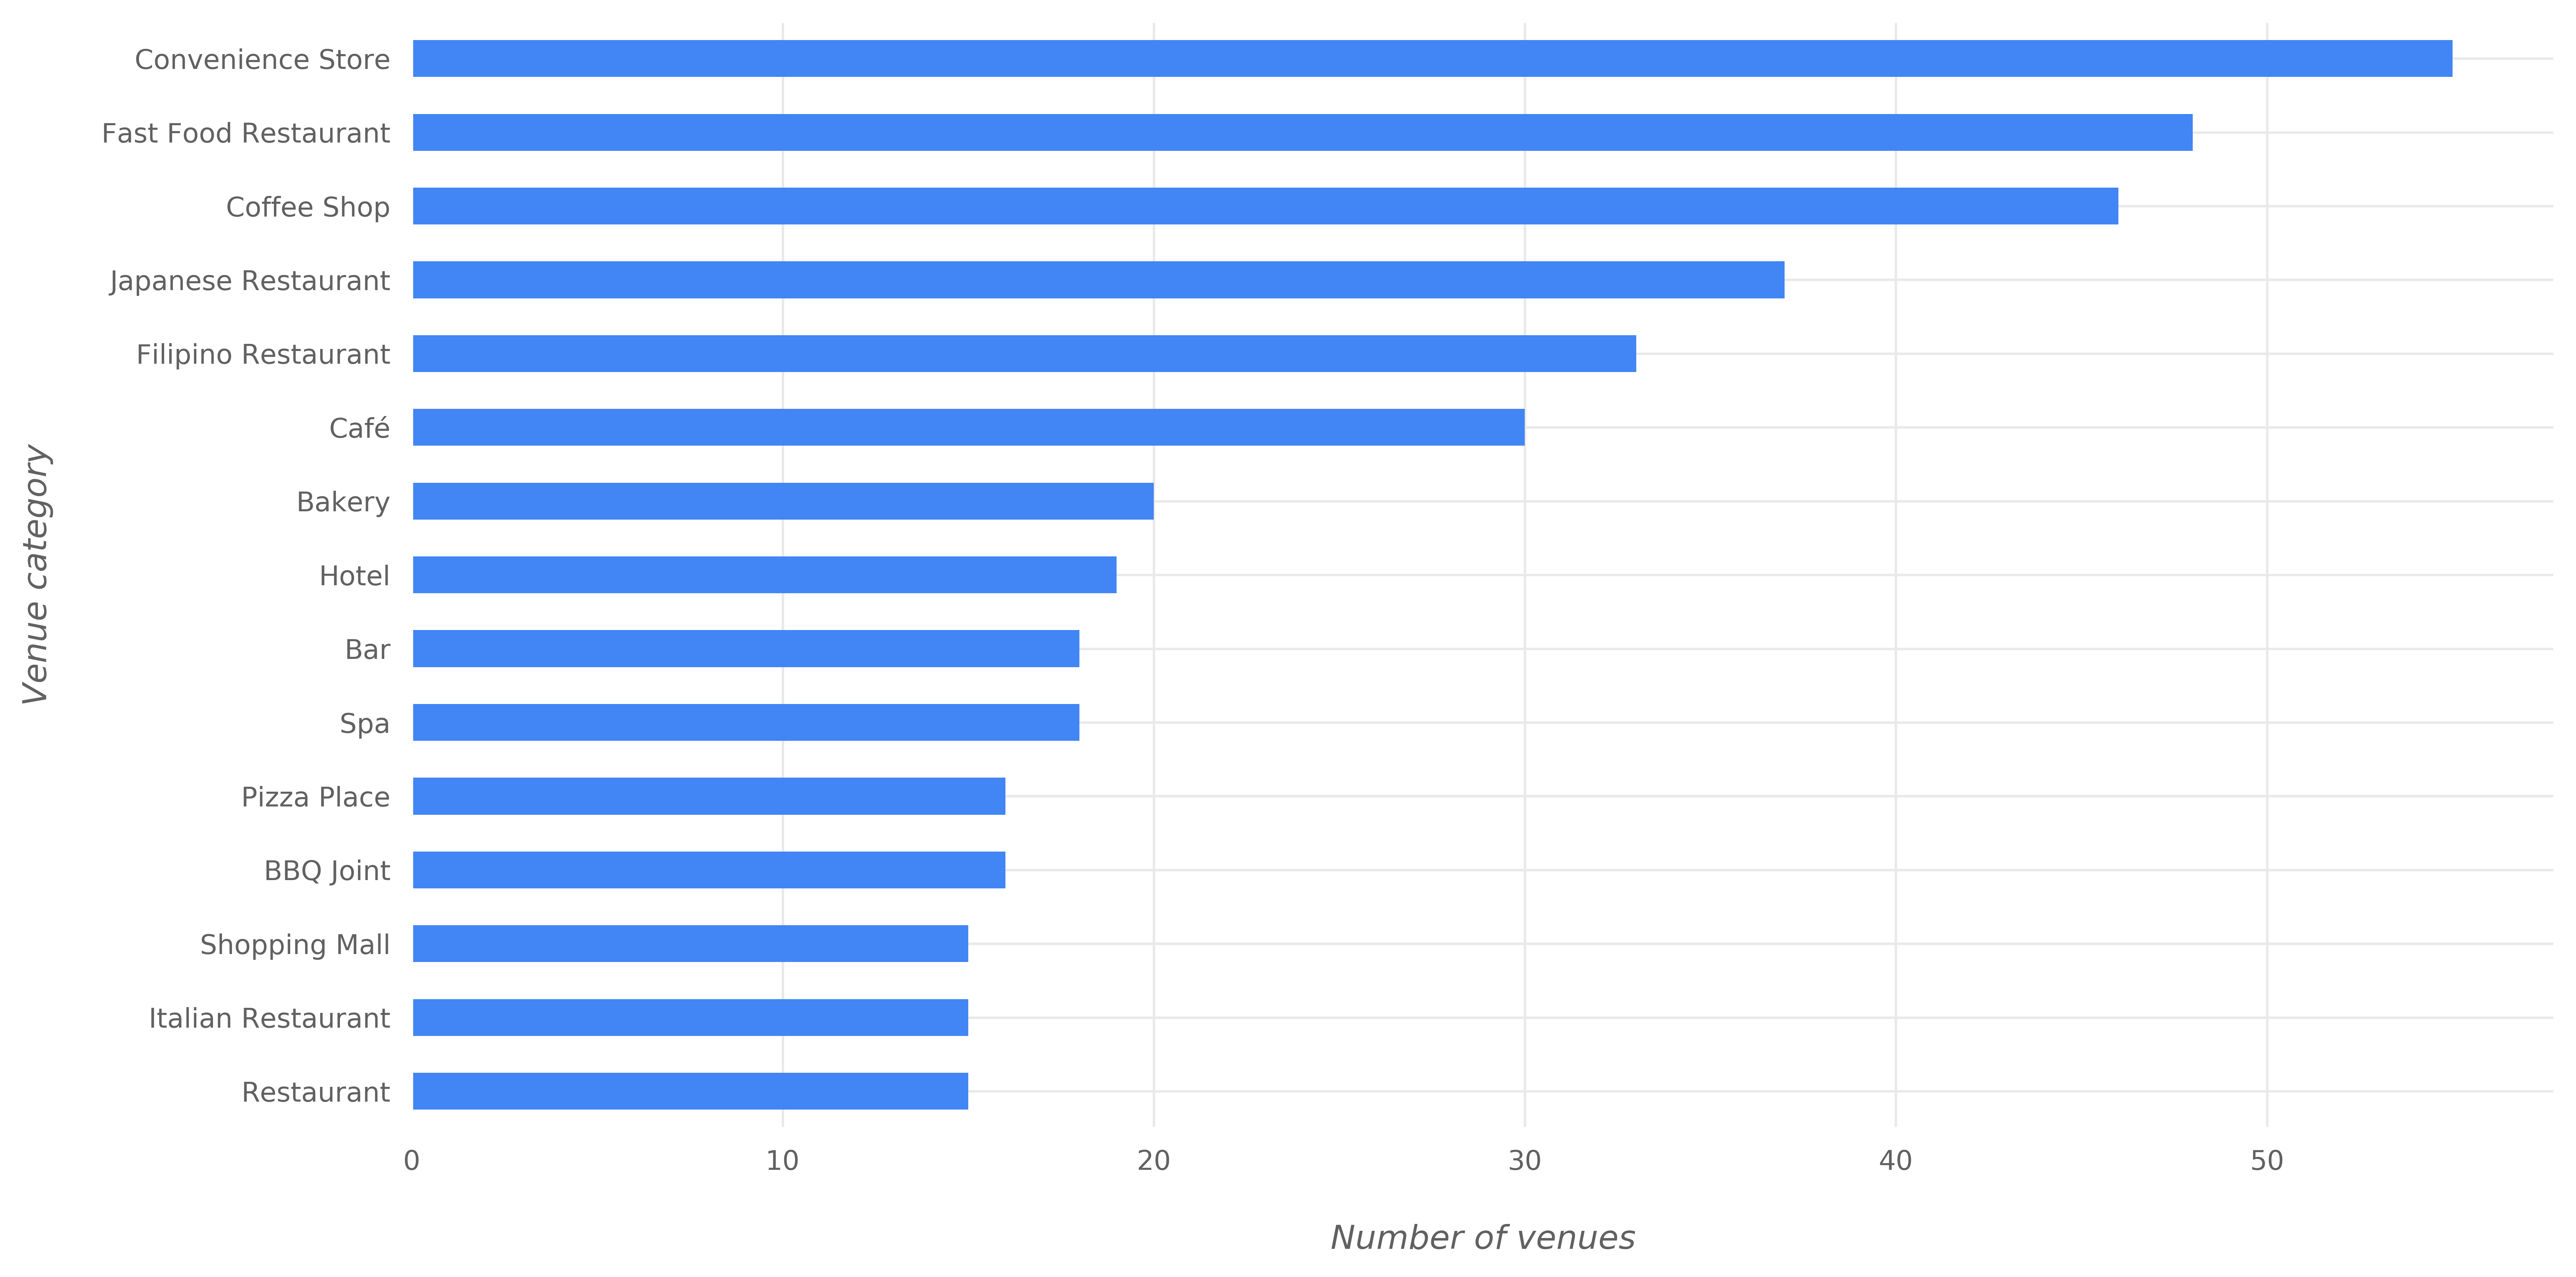

In [228]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt


fig, ax = plt.subplots(figsize=(12,6), facecolor='#ffffff')
makati_top_vc = makati_venues['Venue Category'].value_counts(normalize=False)
ax = makati_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()

plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()


## Visualizing the most common  venues for Mandaluyong City

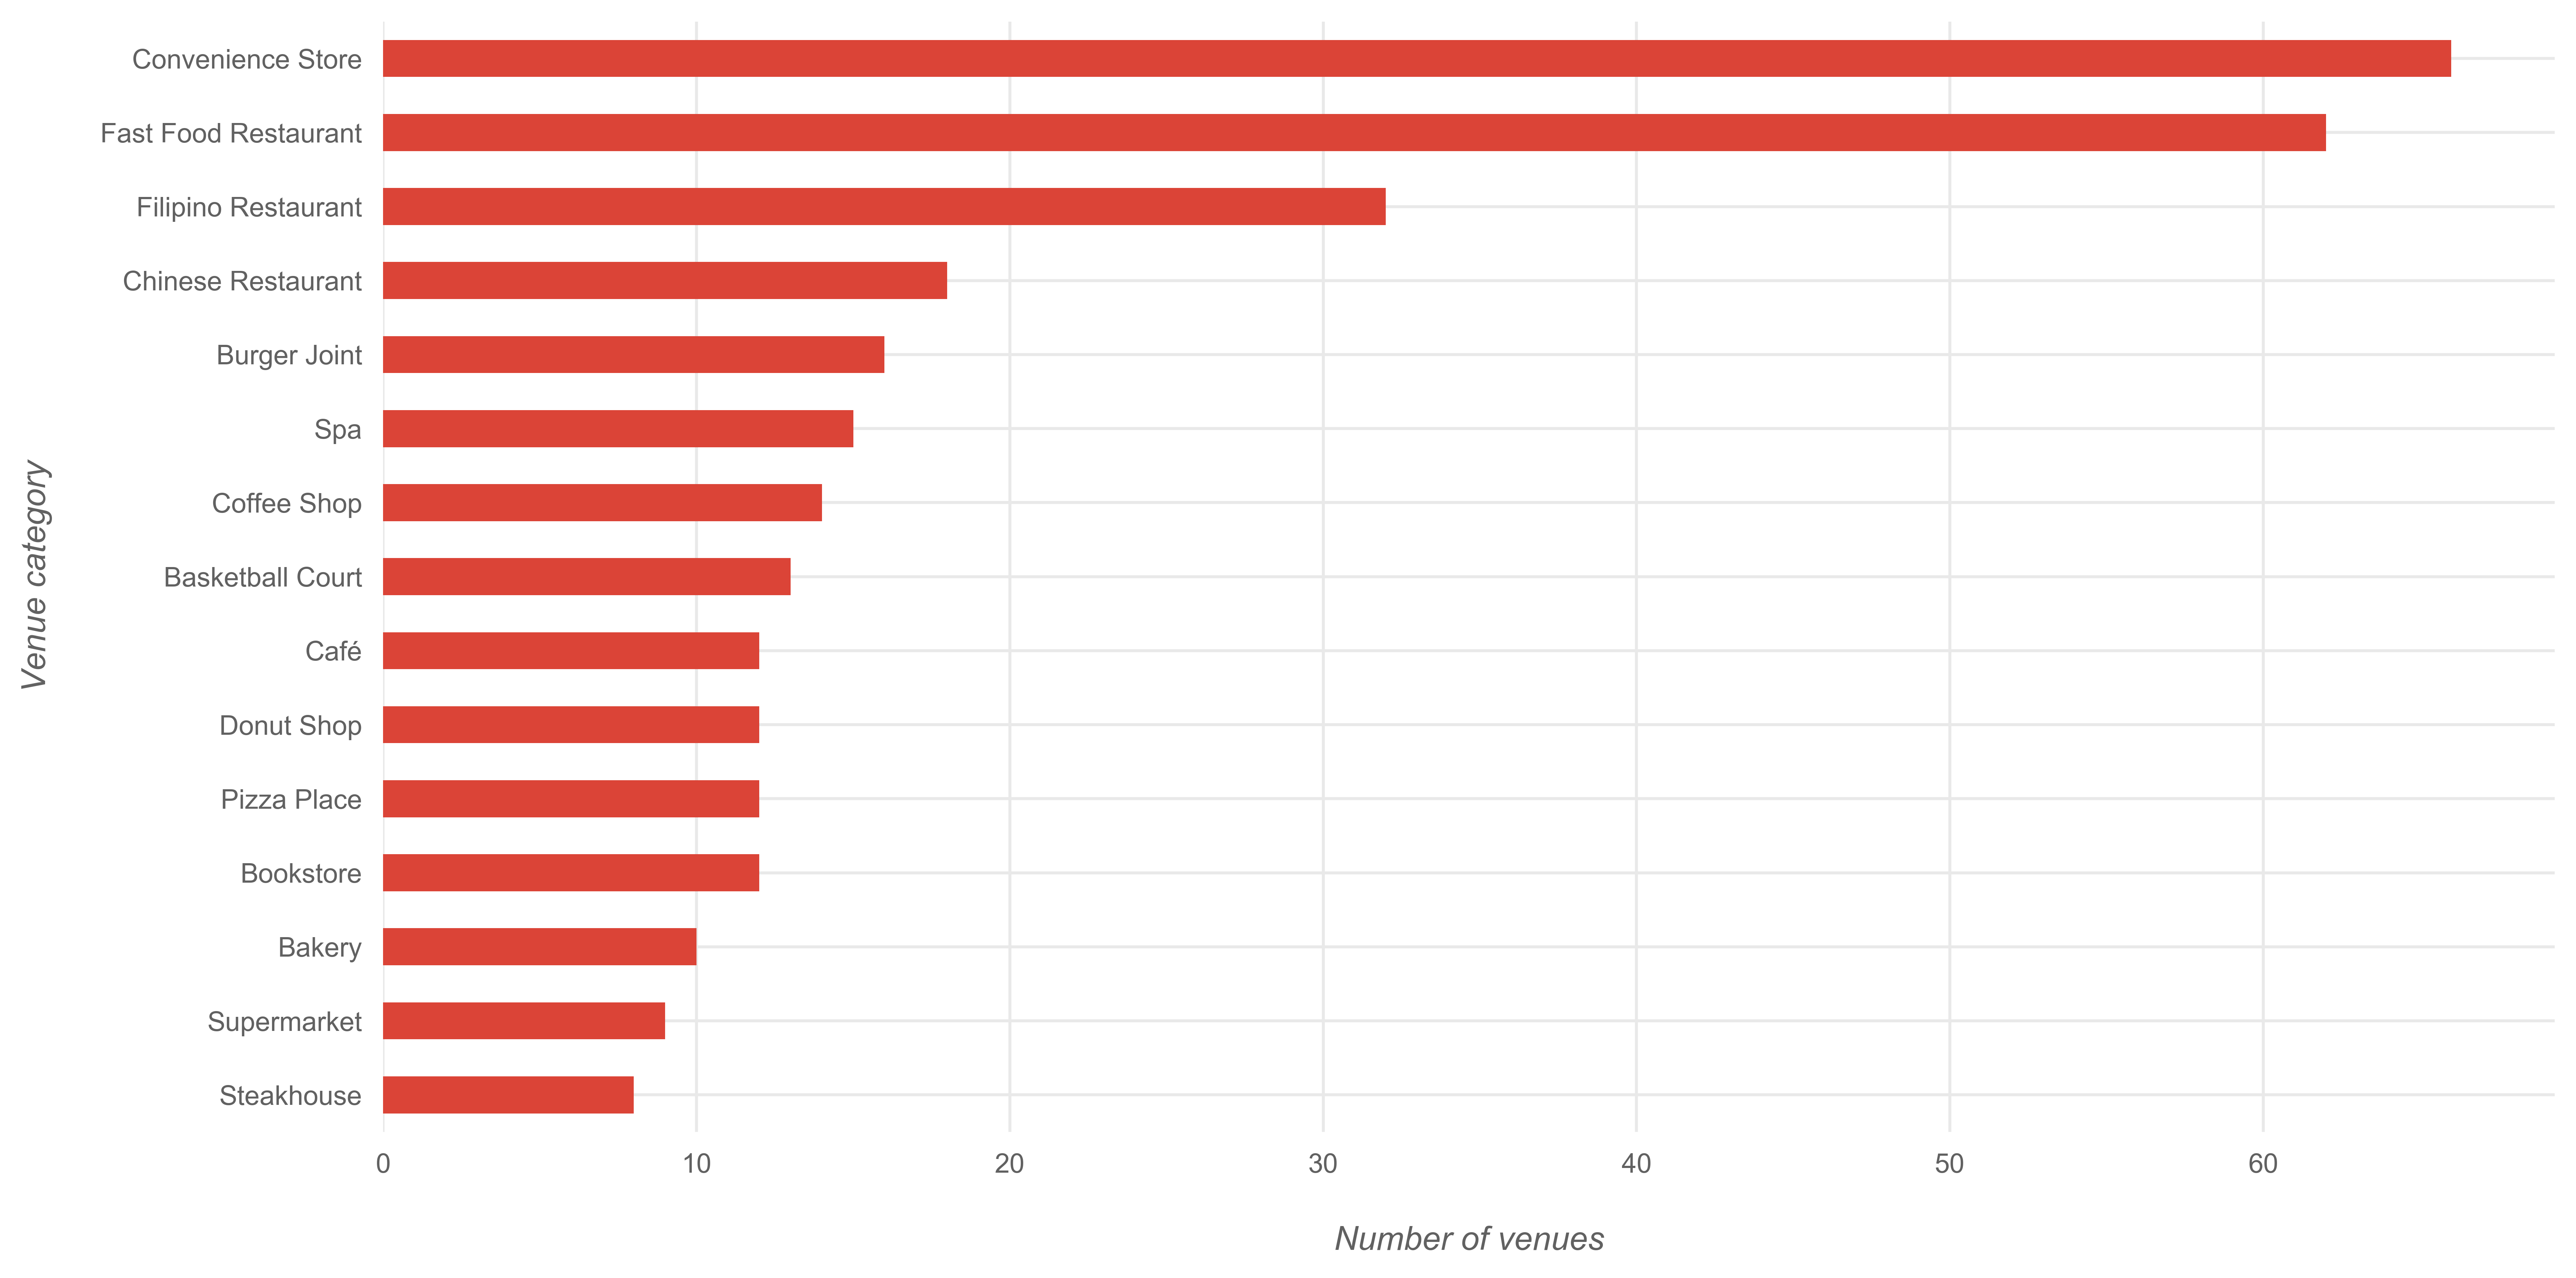

In [427]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='#ffffff')
mandaluyong_top_vc = mandaluyong_venues['Venue Category'].value_counts(normalize=False)
ax = mandaluyong_top_vc.head(15).plot(kind='barh', color=pc[1]);
ax.invert_yaxis()

plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()

## Observing venues that are unique to Makati and Mandaluyong

In [238]:
makati_only_venues = set(makati_grouped.columns).difference(set(mandaluyong_grouped.columns))
mandaluyong_only_venues = set(mandaluyong_grouped.columns).difference(set(makati_grouped.columns))

In [229]:
makati_only_venues

{'Art Gallery',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Australian Restaurant',
 'Baseball Field',
 'Beer Bar',
 'Bike Shop',
 'Bistro',
 'Boutique',
 'Bowling Alley',
 'Brewery',
 'Buffet',
 'Building',
 'Bus Line',
 'Cafeteria',
 'Cantonese Restaurant',
 'Cemetery',
 'Chocolate Shop',
 'Clothing Store',
 'Cocktail Bar',
 'Comic Shop',
 'Cosmetics Shop',
 'Coworking Space',
 'Creperie',
 'Cupcake Shop',
 'Deli / Bodega',
 'Department Store',
 'Dumpling Restaurant',
 'Falafel Restaurant',
 'Farmers Market',
 'Food & Drink Shop',
 'French Restaurant',
 'Frozen Yogurt Shop',
 'Garden',
 'Gas Station',
 'Go Kart Track',
 'Golf Course',
 'Greek Restaurant',
 'Gun Range',
 'Hardware Store',
 'Health Food Store',
 'Hobby Shop',
 'Hostel',
 'Hunan Restaurant',
 'Indian Restaurant',
 'Latin American Restaurant',
 'Lounge',
 'Mattress Store',
 'Mediterranean Restaurant',
 'Mexican Restaurant',
 'Miscellaneous Shop',
 'Mongolian Restaurant',
 'Motel',
 'Movie Theater',
 'Multiplex',
 

In [230]:
mandaluyong_only_venues

{'Auto Garage',
 'Climbing Gym',
 'Electronics Store',
 'Flea Market',
 'Food',
 'Gift Shop',
 'Noodle House',
 'Office',
 'South American Restaurant',
 'Turkish Restaurant'}

## Merging Makati and Mandaluyong venue dataframe

In [313]:
makati_coordinates2 = makati_coordinates

makati_coordinates2['Barangay'] = makati_coordinates['Barangay'].apply(lambda x: x + '_Makati')

mandaluyong_coordinates2 = mandaluyong_coordinates
mandaluyong_coordinates2['Barangay'] = mandaluyong_coordinates2['Barangay'].apply(lambda x: x + '_Mandaluyong')

merged_coords = pd.concat([makati_coordinates2, mandaluyong_coordinates2])

merged_coords

,Barangay,Latitude,Longitude
0,Bangkal_Makati,14.54359,121.01315
1,Bel-Air_Makati,14.56145,121.02362
2,Carmona_Makati,14.57622,121.01725
3,Cembo_Makati,14.56535,121.05088
4,Comembo_Makati,14.54841,121.06393
5,Dasmariñas_Makati,14.53985,121.02822
6,East Rembo_Makati,14.55515,121.06254
7,Forbes Park_Makati,14.54598,121.03687
8,Guadalupe Nuevo_Makati,14.56103,121.04664
9,Guadalupe Viejo_Makati,14.56585,121.04166


In [340]:
merged_coords.reset_index(drop=True, inplace=True)
merged_coords.sort_values('Barangay')

,Barangay,Latitude,Longitude
33,Addition Hills_Mandaluyong,14.58660,121.03829
34,Bagong Silang_Mandaluyong,14.59182,121.03091
0,Bangkal_Makati,14.54359,121.01315
35,Barangka Drive_Mandaluyong,14.57271,121.03796
36,Barangka Ibaba_Mandaluyong,14.57018,121.03926
37,Barangka Ilaya_Mandaluyong,14.57183,121.04789
38,Barangka Itaas_Mandaluyong,14.57132,121.04265
1,Bel-Air_Makati,14.56145,121.02362
39,Buayang Bato_Mandaluyong,14.57403,121.05357
40,Burol_Mandaluyong,14.59007,121.02691


In [236]:
makati_venues_labeled = makati_venues
makati_venues_labeled['Barangay'] = makati_venues['Barangay'].apply(lambda x: x + '_Makati')
makati_venues_labeled.head()

,Barangay,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bangkal_Makati,14.54359,121.01315,100g Burger's,14.545715,121.013222,Burger Joint
1,Bangkal_Makati,14.54359,121.01315,Kaito Japanese Carinderia,14.543683,121.012782,Japanese Restaurant
2,Bangkal_Makati,14.54359,121.01315,FitFast Wellness and Fitness Center,14.547046,121.014352,Gym
3,Bangkal_Makati,14.54359,121.01315,Spare Strike,14.540995,121.011987,Tapas Restaurant
4,Bangkal_Makati,14.54359,121.01315,Nova Gallery,14.544795,121.016941,Art Gallery


In [235]:
mandaluyong_venues_labeled = mandaluyong_venues
mandaluyong_venues_labeled['Barangay'] = mandaluyong_venues['Barangay'].apply(lambda x: x + '_Mandaluyong')
mandaluyong_venues_labeled.head()

,Barangay,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addition Hills_Mandaluyong,14.5866,121.03829,Puñta Comida Callejera,14.588428,121.041284,South American Restaurant
1,Addition Hills_Mandaluyong,14.5866,121.03829,Han Pao Teahouse,14.588300,121.042348,Tea Room
2,Addition Hills_Mandaluyong,14.5866,121.03829,Orgánico Gourmet,14.590390,121.038077,Restaurant
3,Addition Hills_Mandaluyong,14.5866,121.03829,Max's Restaurant,14.589118,121.041923,Fried Chicken Joint
4,Addition Hills_Mandaluyong,14.5866,121.03829,McDonald's,14.589305,121.037035,Fast Food Restaurant


In [240]:
merged_labeled = pd.concat([makati_venues_labeled, mandaluyong_venues_labeled])
merged_labeled

,Barangay,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bangkal_Makati,14.54359,121.01315,100g Burger's,14.545715,121.013222,Burger Joint
1,Bangkal_Makati,14.54359,121.01315,Kaito Japanese Carinderia,14.543683,121.012782,Japanese Restaurant
2,Bangkal_Makati,14.54359,121.01315,FitFast Wellness and Fitness Center,14.547046,121.014352,Gym
3,Bangkal_Makati,14.54359,121.01315,Spare Strike,14.540995,121.011987,Tapas Restaurant
4,Bangkal_Makati,14.54359,121.01315,Nova Gallery,14.544795,121.016941,Art Gallery
5,Bangkal_Makati,14.54359,121.01315,Live Life! Vegetarian Food,14.544767,121.016339,Vegetarian / Vegan Restaurant
6,Bangkal_Makati,14.54359,121.01315,FamilyMart,14.542027,121.011795,Convenience Store
7,Bangkal_Makati,14.54359,121.01315,Finders | Keepers,14.544657,121.017418,Cocktail Bar
8,Bangkal_Makati,14.54359,121.01315,Wilcon Depot,14.542725,121.017588,Hardware Store
9,Bangkal_Makati,14.54359,121.01315,1United,14.544711,121.016420,Sporting Goods Shop


## Applying one-hot encoding

In [250]:
# one hot encoding
merged_onehot = pd.get_dummies(merged_labeled[['Venue Category']], prefix="", prefix_sep="")

# add barangay column back to dataframe
merged_onehot['Barangay'] = merged_labeled['Barangay']

# move neighborhood column to the first column
fixed_columns2 = [merged_onehot.columns[-1]] + list(merged_onehot.columns[:-1])
merged_onehot = merged_onehot[fixed_columns2]

merged_onehot.head()

,Barangay,American Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Cafeteria,Café,Cantonese Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Empanada Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gift Shop,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Hobby Shop,Hospital,Hostel,Hotel,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Motel,Movie Theater,Multiplex,Music Venue,New American Restaurant,Nightclub,Noodle House,Nursery School,Office,Okonomiyaki Restaurant,Outdoor Event Space,Paella Restaurant,Park,Pastry Shop,Pawn Shop,Performing Arts Venue,Perfume Shop,Pet Service,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio
0,Bangkal_Makati,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bangkal_Makati,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bangkal_Makati,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Finding the mean of occurrence

In [251]:
merged_grouped = merged_onehot.groupby('Barangay').mean().reset_index()
merged_grouped.head()

,Barangay,American Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Cafeteria,Café,Cantonese Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Empanada Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gift Shop,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Hobby Shop,Hospital,Hostel,Hotel,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Motel,Movie Theater,Multiplex,Music Venue,New American Restaurant,Nightclub,Noodle House,Nursery School,Office,Okonomiyaki Restaurant,Outdoor Event Space,Paella Restaurant,Park,Pastry Shop,Pawn Shop,Performing Arts Venue,Perfume Shop,Pet Service,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio
0,Addition Hills_Mandaluyong,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.076923,0.0,0.153846,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.076923,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.076923,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bagong Silang_Mandaluyong,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.035714,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0

In [254]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Barangay']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) # 1st, 2nd, 3rd
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
merged_venues_sorted = pd.DataFrame(columns=columns)
merged_venues_sorted['Barangay'] = merged_grouped['Barangay']

# Each row of the new dataframe is filled with the sorted categories of each row of makati_goruped dataframe
for ind in np.arange(merged_grouped.shape[0]):
    merged_venues_sorted.iloc[ind, 1:] = return_most_common_venues(merged_grouped.iloc[ind, :], num_top_venues)

merged_venues_sorted

,Barangay,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addition Hills_Mandaluyong,Convenience Store,Basketball Court,Restaurant,Bar,South American Restaurant,Tea Room,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Shopping Mall
1,Bagong Silang_Mandaluyong,Fast Food Restaurant,Filipino Restaurant,Convenience Store,Chinese Restaurant,Bookstore,Salon / Barbershop,Supermarket,Spa,Donut Shop,Café
2,Bangkal_Makati,Convenience Store,Art Gallery,Fast Food Restaurant,Nightclub,Cocktail Bar,Furniture / Home Store,Bar,Gym,Donut Shop,Resort
3,Barangka Drive_Mandaluyong,Convenience Store,Diner,Spa,Bridal Shop,Fish Market,Filipino Restaurant,Pharmacy,Fast Food Restaurant,Shoe Store,Massage Studio
4,Barangka Ibaba_Mandaluyong,Fast Food Restaurant,Taco Place,Hotel,Bar,Yoga Studio,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
5,Barangka Ilaya_Mandaluyong,Filipino Restaurant,Fast Food Restaurant,Sandwich Place,American Restaurant,Burger Joint,Hotel,Massage Studio,Health & Beauty Service,Donut Shop,Dance Studio
6,Barangka Itaas_Mandaluyong,Convenience Store,Fast Food Restaurant,Burger Joint,Fish Market,Bubble Tea Shop,Noodle House,Grocery Store,Tea Room,Bookstore,Spanish Restaurant
7,Bel-Air_Makati,Coffee Shop,Restaurant,Spa,Japanese Restaurant,Steakhouse,Café,Pizza Place,Yoga Studio,Mediterranean Restaurant,Sushi Restaurant
8,Buayang Bato_Mandaluyong,Korean Restaurant,Coffee Shop,Japanese Restaurant,Bubble Tea Shop,Bakery,Filipino Restaurant,Steakhouse,Fast Food Restaurant,Climbing Gym,Supermarket
9,Burol_Mandaluyong,Fast Food Restaurant,Convenience Store,Café,Bakery,Snack Place,Flea Market,Filipino Restaurant,Burger Joint,Pharmacy,Bookstore


## Applying K-Means clustering

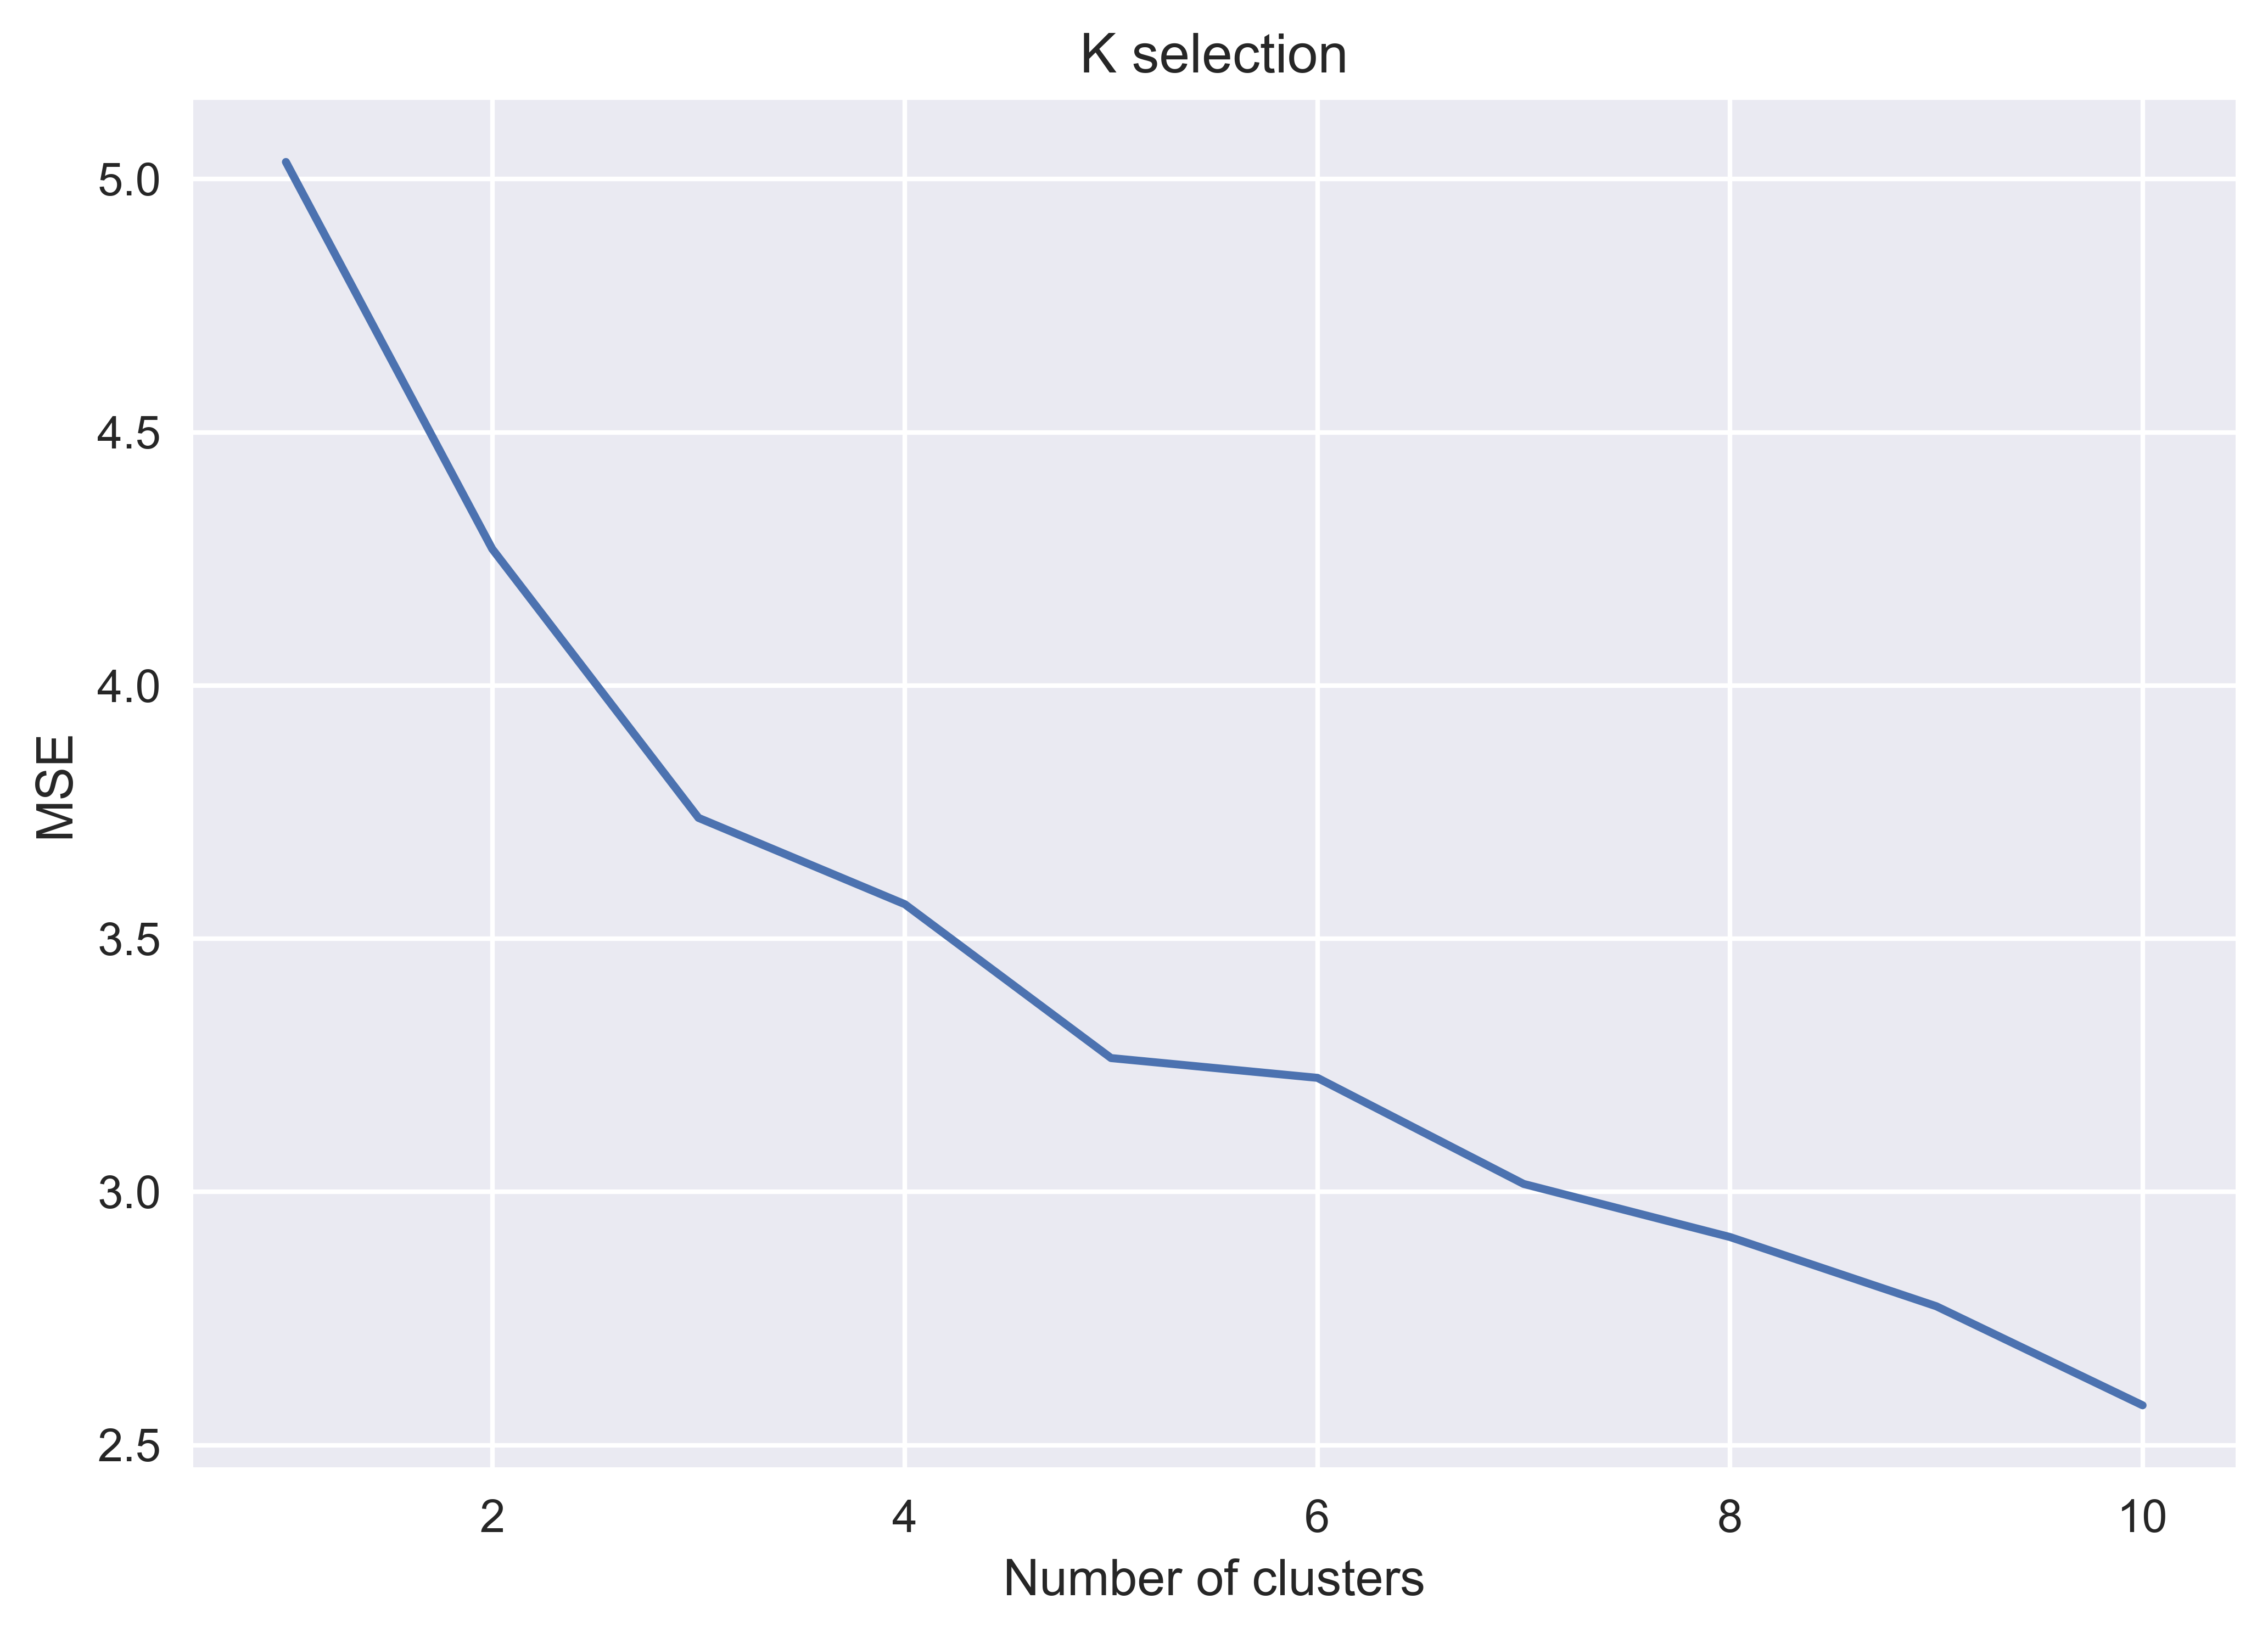

In [256]:
# Finding best k
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
merged_grouped_clustering = merged_grouped.drop(['Barangay'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(merged_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [257]:
kclusters = 3


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(merged_grouped_clustering)

kmeans.labels_[0:10]

array([2, 0, 2, 2, 0, 1, 2, 1, 1, 0])

In [386]:
#create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
merged = merged_coords.copy()

# add clustering labels
merged["Cluster Labels"] = kmeans.labels_

merged = merged.merge(merged_venues_sorted.set_index('Barangay'), on='Barangay')
merged.drop(columns=['Cluster Labels_x'], axis=1, inplace=True)
merged = merged.rename(columns={'Cluster Labels_y': 'Cluster Labels'})
merged.set_index('Barangay',inplace=True)
merged.head()

,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Barangay,,,,,,,,,,,,,
Bangkal_Makati,14.54359,121.01315,2,Convenience Store,Art Gallery,Fast Food Restaurant,Nightclub,Cocktail Bar,Furniture / Home Store,Bar,Gym,Donut Shop,Resort
Bel-Air_Makati,14.56145,121.02362,1,Coffee Shop,Restaurant,Spa,Japanese Restaurant,Steakhouse,Café,Pizza Place,Yoga Studio,Mediterranean Restaurant,Sushi Restaurant
Carmona_Makati,14.57622,121.01725,1,Convenience Store,Coffee Shop,Fast Food Restaurant,BBQ Joint,Burrito Place,Shopping Plaza,Fried Chicken Joint,Burger Joint,Café,Outdoor Event Space
Cembo_Makati,14.56535,121.05088,2,Park,Basketball Court,Convenience Store,Pharmacy,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
Comembo_Makati,14.54841,121.06393,0,Fast Food Restaurant,Convenience Store,Diner,Fish Market,Asian Restaurant,Breakfast Spot,Chinese Restaurant,Gym / Fitness Center,Frozen Yogurt Shop,Fried Chicken Joint


## Visualizing the cluster using Folium

In [329]:
map_clusters3 = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, brgy, cluster in zip(merged['Latitude'], merged['Longitude'],
                                merged['Barangay'], merged['Cluster Labels']):
    label = folium.Popup('{} - Cluster {}'.format(brgy, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters3)
       
map_clusters3

## Examining the clusters

In [331]:
merged.groupby('Cluster Labels').count()

,Barangay,Latitude,Longitude
Cluster Labels,,,
0,13,13,13
1,25,25,25
2,22,22,22


## Cluster 0

In [387]:
merged.loc[merged['Cluster Labels'] == 0]

,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Barangay,,,,,,,,,,,,,
Comembo_Makati,14.54841,121.06393,0,Fast Food Restaurant,Convenience Store,Diner,Fish Market,Asian Restaurant,Breakfast Spot,Chinese Restaurant,Gym / Fitness Center,Frozen Yogurt Shop,Fried Chicken Joint
East Rembo_Makati,14.55515,121.06254,0,Fast Food Restaurant,Basketball Court,Breakfast Spot,Filipino Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
Guadalupe Viejo_Makati,14.56585,121.04166,0,Fast Food Restaurant,Convenience Store,Restaurant,Café,Dumpling Restaurant,Taco Place,Bakery,Boutique,Cosmetics Shop,Market
San Isidro_Makati,14.55340,121.00564,0,Fast Food Restaurant,Filipino Restaurant,Chinese Restaurant,Pharmacy,Restaurant,Pizza Place,Cupcake Shop,Food Court,Hotel,Ramen Restaurant
West Rembo_Makati,14.56162,121.05954,0,Fast Food Restaurant,Convenience Store,Breakfast Spot,Soccer Stadium,Tapas Restaurant,Pool,Coffee Shop,Chinese Restaurant,Sandwich Place,Gastropub
Bagong Silang_Mandaluyong,14.59182,121.03091,0,Fast Food Restaurant,Filipino Restaurant,Convenience Store,Chinese Restaurant,Bookstore,Salon / Barbershop,Supermarket,Spa,Donut Shop,Café
Barangka Ibaba_Mandaluyong,14.57018,121.03926,0,Fast Food Restaurant,Taco Place,Hotel,Bar,Yoga Studio,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
Burol_Mandaluyong,14.59007,121.02691,0,Fast Food Restaurant,Convenience Store,Café,Bakery,Snack Place,Flea Market,Filipino Restaurant,Burger Joint,Pharmacy,Bookstore
Daang Bakal_Mandaluyong,14.59296,121.02866,0,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Bookstore,Filipino Restaurant,Pizza Place,Supermarket,Breakfast Spot,Café,Snack Place


## Cluster 1

In [388]:
merged.loc[merged['Cluster Labels'] == 1]

,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Barangay,,,,,,,,,,,,,
Bel-Air_Makati,14.56145,121.02362,1,Coffee Shop,Restaurant,Spa,Japanese Restaurant,Steakhouse,Café,Pizza Place,Yoga Studio,Mediterranean Restaurant,Sushi Restaurant
Carmona_Makati,14.57622,121.01725,1,Convenience Store,Coffee Shop,Fast Food Restaurant,BBQ Joint,Burrito Place,Shopping Plaza,Fried Chicken Joint,Burger Joint,Café,Outdoor Event Space
Dasmariñas_Makati,14.53985,121.02822,1,Café,Gym,Soccer Field,Baseball Field,Yoga Studio,Filipino Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
Forbes Park_Makati,14.54598,121.03687,1,Japanese Restaurant,Italian Restaurant,Lounge,Deli / Bodega,Coffee Shop,Café,Bookstore,Indian Restaurant,Grocery Store,Golf Course
La Paz_Makati,14.56834,121.00936,1,Filipino Restaurant,Hotel,Bar,Pizza Place,Bistro,Gas Station,Burger Joint,Coffee Shop,Donut Shop,Bubble Tea Shop
Magallanes_Makati,14.53534,121.01797,1,Diner,Coffee Shop,Pizza Place,Ice Cream Shop,Mongolian Restaurant,Donut Shop,Salad Place,Food & Drink Shop,Café,Paella Restaurant
Olympia_Makati,14.56933,121.01916,1,Convenience Store,Filipino Restaurant,Donut Shop,Fast Food Restaurant,Diner,Beer Garden,Soup Place,Café,Dim Sum Restaurant,Pastry Shop
Palanan_Makati,14.55996,121.00275,1,Pharmacy,Pizza Place,Filipino Restaurant,Fast Food Restaurant,Bakery,Coffee Shop,Garden,Dessert Shop,Food Court,Supermarket
Pio del Pilar_Makati,14.55379,121.01069,1,Japanese Restaurant,Pizza Place,Convenience Store,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Bookstore,Tea Room,Diner,Donut Shop


## Cluster 2

In [389]:
merged.loc[merged['Cluster Labels'] == 2]

,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Barangay,,,,,,,,,,,,,
Bangkal_Makati,14.54359,121.01315,2,Convenience Store,Art Gallery,Fast Food Restaurant,Nightclub,Cocktail Bar,Furniture / Home Store,Bar,Gym,Donut Shop,Resort
Cembo_Makati,14.56535,121.05088,2,Park,Basketball Court,Convenience Store,Pharmacy,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
Guadalupe Nuevo_Makati,14.56103,121.04664,2,Convenience Store,Fast Food Restaurant,Basketball Court,Motel,Bus Line,Pawn Shop,Breakfast Spot,Farmers Market,Bakery,Pet Store
Kasilawan_Makati,14.57592,121.01331,2,Convenience Store,Juice Bar,BBQ Joint,Supermarket,Fried Chicken Joint,Cafeteria,Fast Food Restaurant,Shop & Service,Bakery,Sports Club
Pembo_Makati,14.54519,121.05978,2,Convenience Store,Soba Restaurant,Pizza Place,Fast Food Restaurant,Farmers Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
Pinagkaisahan_Makati,14.55765,121.04030,2,Basketball Court,Sandwich Place,Drugstore,Convenience Store,Breakfast Spot,Grocery Store,Filipino Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
Rizal_Makati,14.53730,121.06097,2,Department Store,Breakfast Spot,Convenience Store,Bus Station,Gym,Fish Market,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck
Singkamas_Makati,14.57249,121.01110,2,Convenience Store,Intersection,Filipino Restaurant,Soup Place,Spa,Drugstore,Hostel,Market,Donut Shop,Food Truck
Valenzuela_Makati,14.57099,121.02427,2,Convenience Store,Filipino Restaurant,Bakery,Gym / Fitness Center,Malay Restaurant,Brewery,Diner,Seafood Restaurant,Boutique,Fast Food Restaurant
